In [ ]:
from tqdm.notebook import tqdm
import numpy as np
from scipy.stats import pearsonr, skew, boxcox
from sklearn.model_selection import train_test_split

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

from ds100_utils import *
from feature_func import *

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

with zipfile.ZipFile('cook_county_train.zip') as item:
    item.extractall()
initial_data = pd.read_csv("cook_county_train.csv", index_col='Unnamed: 0')
initial_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

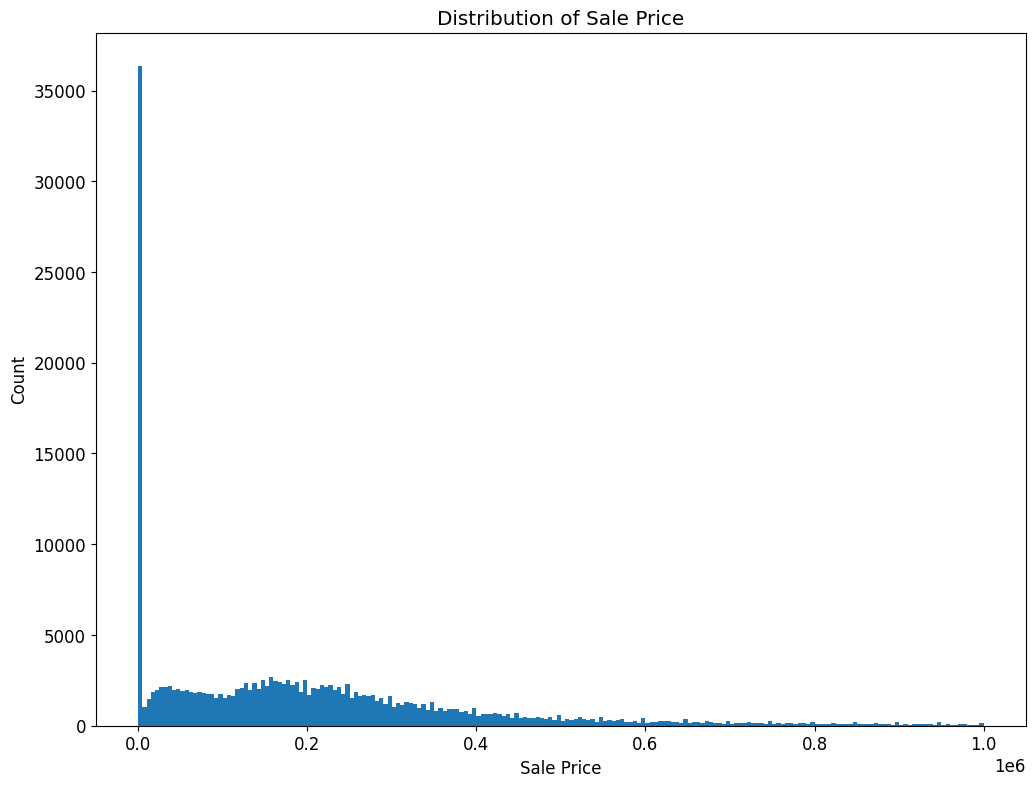

In [19]:
def plot_distribution(data, label):
    fig, axs = plt.subplots(nrows=2)

    sns.distplot(
        data[label], 
        ax=axs[0]
    )
    sns.boxplot(
        x=data[label],
        width=0.3, 
        ax=axs[1],
        showfliers=False,
    )

    # Align axes
    spacer = np.max(data[label]) * 0.05
    xmin = np.min(data[label]) - spacer
    xmax = np.max(data[label]) + spacer
    axs[0].set_xlim((xmin, xmax))
    axs[1].set_xlim((xmin, xmax))

    # Remove some axis text
    axs[0].xaxis.set_visible(False)
    axs[0].yaxis.set_visible(False)
    axs[1].yaxis.set_visible(False)

    # Put the two plots together
    plt.subplots_adjust(hspace=0)
    fig.suptitle("Distribution of " + label)
no_right_outliers = initial_data[initial_data['Sale Price'] <= 1000000]['Sale Price']
plt.hist(no_right_outliers, bins=200)
plt.xlabel("Sale Price")
plt.ylabel("Count")
plt.title("Distribution of Sale Price")
plt.show()

In [ ]:
full_data = pd.read_csv("cook_county_train.csv")
full_data["Log Sale Price"] = np.log(full_data["Sale Price"])
feature_ohe_lst = ["Property Class",  "Basement", "Garage Indicator", "Repair Condition", "Use"]
feature_ohe_lst_not = ["Central Air","Neighborhood Code","Attic Finish", "Garage 1 Material", "Garage 2 Size", "Garage 2 Material", ]
feature_ohe_lst += feature_ohe_lst_not

In [24]:
city_center = (41.88386, -87.631631)  
hinsdale = (41.80086, -87.93701)
linc_park = (41.928195, -87.646511)
gold_coast = (41.9067, 87.6253)
lake_forest = (42.245686, -87.867012)
one_hot_cols = []  
target_enc_columns = ['Town and Neighborhood']
log_required = ["Land Square Feet", "Building Square Feet", "Estimate (Land)", "Estimate (Building)", "Lot Size"]
def remove_outlier_iqr(data, col):
    """ sr = data[col].describe()
    Q1 = sr['25%']
    Q3 = sr['75%']
    IQR = Q3 - Q1
    iqr_bot = Q1 - 1.5 * IQR
    iqr_top = Q3 + 1.5 * IQR
    data = data[(data[col] >= iqr_bot) & (data[col] <= iqr_top)]
    data = data.reset_index(drop=True) """
    data = data[data['Sale Price'] >= 10000]  # Lower bound outlier removal
    data = data[data['Sale Price'] < 10000000.0].reset_index(drop=True)  # Upper bound outlier removal
    return data

def mean_encode(data, cols):
    frame = pd.DataFrame()
    for col in cols:
        mapper = dict(full_data.groupby(col)['Sale Price'].mean())
        mu= np.mean(list(mapper.values()))
        frame[col] = data[col].map(mapper, na_action='ignore')
        frame[col] = data[col].fillna(mu)
        frame[col] = np.log(data[col])
    return frame

def calculate_distance(data, point, point_name='CityCenter'):
    data[f'Distance_to_{point_name}'] = np.sqrt(
        (data['Latitude'] - point[0])**2 + (data['Longitude'] - point[1])**2
    )
    return data

def add_location_clusters(data, n_clusters=10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    data['Location Cluster'] = kmeans.fit_predict(data[['Longitude', 'Latitude']])
    return data
def quant_transform(data, cols):
    frame = pd.DataFrame()
    for col in cols:
        if data[col].min() <=0:
            data[col] += 0.1
        frame[col] = np.log(data[col])
        frame = frame.fillna(0.0)
    return frame
def add_story(data):
    with_rooms = pd.DataFrame()
    with_rooms['story'] = data['Description'].str.findall(r"([a-zA-Z]+)-story[\w\s]*houeshold").str[0]
    mapping = {'one':1.0, 'two':2.0, 'three':3.0}
    with_rooms['story'] = with_rooms['story'].map(mapping, na_action='ignore')
    with_rooms['story'] = with_rooms['story'].fillna(1.0)
    return with_rooms
def remove_upper_outlier(df, column='Sale Price', threshold=1e7):
    return df[df[column] < threshold].reset_index(drop=True)
df_filter = remove_upper_outlier(remove_outliers(full_data, 'Sale Price', lower=500))
def create_target_enc_mappings(df, target_column='Sale Price'):
    col_and_mapping = {
        col: {
            'mean': df[target_column].mean(),
            'mapping': df.groupby(col)[target_column].mean().to_dict()
        }
        for col in target_enc_columns
    }
    return col_and_mapping
col_and_mapping = create_target_enc_mappings(df_filter)
def mean_encode(df, mappings):
    data = pd.DataFrame()
    for col, details in mappings.items():
        data[col] = df[col].map(details['mapping']).fillna(details['mean'])
        data[col] = np.log(data[col])
    return data
def one_hot(df, cols):
    data = pd.DataFrame()
    for col in cols:
        ohe = OneHotEncoder(handle_unknown='ignore')
        encoded = ohe.fit_transform(df[[col]]).toarray()
        encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out([col]))
        data = data.join(encoded_df).drop(columns=col)
    return data
def apply_log_transform(df, cols):
    data = pd.DataFrame()
    for col in cols:
        if df[col].min() <= 0:
            df[col] += 0.1
        data[col] = np.log(df[col])
    return data
def quant_pipeline(df):
    data = pd.DataFrame()
    data = mean_encode(df, col_and_mapping)
    data = pd.concat([data, apply_log_transform(df, log_required)], axis=1)
    data = data.fillna(0.0)
    return data
def story(df):
    data = pd.DataFrame()
    data['story'] = df['Description'].str.extract(r"([a-zA-Z]+)-story")
    data['story'] = data['story'].map({'one': 1.0, 'two': 2.0, 'three': 3.0}).fillna(1.0)
    return data
def rooms(data):
    pat_bedrooms = r"([\d]) of which are bedrooms"
    bedrooms = data["Description"].str.extract(pat_bedrooms)[0].astype(int)
    """ pat_rooms = r'total of (\d+) rooms'
    rooms = data["Description"].str.extract(pat_rooms)[0].astype(int) """
    pat_bath = r"([0-9]{1}\.[0-9]{1}) of which are bathrooms"
    bath = data['Description'].str.extract(pat_bath)[0].astype(float)
    rooms_df = pd.DataFrame({
        "Bedrooms": bedrooms,
        "Bathrooms": bath
    }, index=data.index)
    return rooms_df


In [26]:
def feature_engine_final(data, is_test_set=False):
    # Whenever you access 'Log Sale Price' or 'Sale Price', make sure to use the
    # condition is_test_set like this:
    if not is_test_set:
        # Processing for the training set (i.e. not the test set)
        # CAN involve references to sale price!
        # CAN involve filtering certain rows or removing outliers
        data = data.reset_index(drop=True)
        data = data[data['Sale Price'] >= 10000]  # Lower bound outlier removal
        data = data[data['Sale Price'] < 10000000.0].reset_index(drop=True)  # Upper bound outlier removal
        data['Log Sale Price'] = np.log(data['Sale Price'])
        design = quant_pipeline(data)
    else:
        # Processing for the test set
        # CANNOT involve references to sale price!
        # CANNOT involve removing any rows
        data = data.reset_index(drop=True)
        design = quant_pipeline(data)
        
    # Processing for both test and training set
    # CANNOT involve references to sale price!
    # CANNOT involve removing any rows
    scaler = StandardScaler()
    temp_df = pd.DataFrame()

    if is_test_set:
        # Predictors 
        X_scaled = scaler.fit_transform(design)  # Fit and transform
        #X_hot = add_one_hot(data, one_hot_cols).to_numpy()
        X= np.concatenate((X_scaled, story(data).to_numpy()),axis=1)
        X = np.concatenate((X, rooms(data).to_numpy()),axis=1)
        return X
    else:
        # Predictors. Your X should not include Log Sale Price!
        X_scaled = scaler.fit_transform(design)
        #X_hot = add_one_hot(data,one_hot_cols).to_numpy()
        #X = np.concatenate((X_scaled, X_hot), axis=1)
        X= np.concatenate((X_scaled, story(data).to_numpy()),axis=1)
        X = np.concatenate((X, rooms(data).to_numpy()),axis=1)
        Y = data['Log Sale Price']
        return X, Y

check_rmse_threshold = run_linear_regression_test_optim(lm.LinearRegression(fit_intercept=True), feature_engine_final, 'cook_county_train.csv', None, False)
print("Current training RMSE:", check_rmse_threshold.loss)

Current training RMSE: 146599.77480747606
